# Load some modules

In [1]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('../../')
from draw_embeddings import draw_embeddings

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

# Load the covariates data

In [4]:
classes = pd.read_csv("../ExposomeChallengeData/datasets/covariates_cat.csv", index_col=0)
classes.head()

,cohort,age,sex,education,native,parity
1,3,1,0,1,2,0
2,3,2,0,2,2,1
3,3,1,0,2,2,1
4,1,4,1,0,2,1
5,2,4,0,0,2,0


# Load the exposome data

In [5]:
metabol_serum_exprs = pd.read_csv("../ExposomeChallengeData/datasets/metabol_serum_exprs.csv", index_col=0).T
metabol_urine_exprs = pd.read_csv("../ExposomeChallengeData/datasets/metabol_urine_exprs.csv", index_col=0).T
metabol_exprs = pd.concat([metabol_serum_exprs.rename('serum_{}'.format, axis=1),
                           metabol_urine_exprs.rename('urine_{}'.format, axis=1)], axis=1)
metabol_exprs.index = metabol_exprs.index.astype(int) # Force index (row names) into int type
metabol_exprs.head()

,serum_metab_1,serum_metab_2,serum_metab_3,serum_metab_4,serum_metab_5,serum_metab_6,serum_metab_7,serum_metab_8,serum_metab_9,serum_metab_10,...,urine_metab_35,urine_metab_36,urine_metab_37,urine_metab_38,urine_metab_39,urine_metab_40,urine_metab_41,urine_metab_42,urine_metab_43,urine_metab_44
430,-2.145605,-0.714302,8.599913,0.552377,7.051481,5.785289,3.747387,5.070389,-1.867752,-2.771027,...,5.185867,5.057450,12.117805,2.906891,4.446256,4.529821,3.877744,-0.152003,3.087463,2.459432
1187,-0.685014,-0.368663,9.154818,-1.334607,6.894211,5.806066,4.257765,5.083213,-2.300448,-3.418890,...,4.977280,7.870365,11.985735,-4.321928,4.990955,4.738768,-0.321928,0.263034,2.944858,2.584963
940,-0.685014,-0.361231,8.954196,-0.127368,7.104861,5.859224,4.345538,5.918863,-1.965784,-3.403542,...,4.986411,5.040016,12.200040,-4.321928,4.104337,4.385431,3.817623,-4.321928,3.744161,2.981853
936,-0.194295,-0.339163,8.535275,-0.618163,7.007308,5.950702,4.242603,5.405992,-1.894322,-2.841663,...,4.827819,6.697663,11.570899,-2.321928,4.765535,3.292782,3.017922,-4.321928,3.990955,3.523562
788,-1.960160,-0.346481,8.727920,-0.797112,6.895424,5.950702,4.884109,5.388878,-1.552156,-2.454032,...,4.754888,5.221104,11.679524,-0.321928,3.700440,4.781360,3.201634,-0.321928,2.765535,2.944858


# Correct for the batch effect

While exploring the exposome data, I found that de clusters overlapped too well with the cohort classes, which suggests a strong batch effect. I'll try to correct for that and re-evaluate the clustering methods.

Subset the data by cohort group and standarize each subset individually, then rejoin the data and min-max normalize it.

In [6]:
for c in set(classes.cohort):
    index = classes.cohort == c
    metabol_exprs.loc[index, :] = StandardScaler().fit_transform(metabol_exprs.loc[index, :])
metabol_exprs.head()

,serum_metab_1,serum_metab_2,serum_metab_3,serum_metab_4,serum_metab_5,serum_metab_6,serum_metab_7,serum_metab_8,serum_metab_9,serum_metab_10,...,urine_metab_35,urine_metab_36,urine_metab_37,urine_metab_38,urine_metab_39,urine_metab_40,urine_metab_41,urine_metab_42,urine_metab_43,urine_metab_44
430,-1.536876,-1.547101,-0.386913,1.468692,0.289090,-0.017564,-1.067460,-1.067203,-0.086043,0.334836,...,-0.410613,-0.178519,0.192113,-0.016825,0.145993,0.540852,0.742487,0.935132,-0.873971,-0.874881
1187,0.154154,0.485053,1.581406,-1.459250,-0.370490,0.058575,0.263448,-1.018215,-1.122316,-1.055874,...,-0.763376,1.706809,-0.138475,-2.856316,1.292355,0.838233,-2.098999,1.114924,-1.014449,-0.716685
940,0.154154,0.528747,0.869775,0.413964,0.512962,0.253374,0.492334,2.173977,-0.320822,-1.022927,...,-0.747934,-0.190205,0.397957,-2.856316,-0.573604,0.335350,0.701810,-0.871264,-0.227067,-0.216517
936,0.722294,0.658497,-0.616191,-0.347578,0.103829,0.588595,0.223909,0.214804,-0.149675,0.183209,...,-1.016145,0.920817,-1.176859,-2.070713,0.817941,-1.219753,0.160734,-0.871264,0.016047,0.466156
788,-1.322173,0.615467,0.067146,-0.625245,-0.365406,0.588595,1.896762,0.149428,0.669784,1.015303,...,-1.139487,-0.068832,-0.904958,-1.285110,-1.423637,0.898852,0.285033,0.861521,-1.191098,-0.263137


In [7]:
metabol_exprs.iloc[:,:] = MinMaxScaler().fit_transform(metabol_exprs)
metabol_exprs.head()

,serum_metab_1,serum_metab_2,serum_metab_3,serum_metab_4,serum_metab_5,serum_metab_6,serum_metab_7,serum_metab_8,serum_metab_9,serum_metab_10,...,urine_metab_35,urine_metab_36,urine_metab_37,urine_metab_38,urine_metab_39,urine_metab_40,urine_metab_41,urine_metab_42,urine_metab_43,urine_metab_44
430,0.255805,0.174073,0.455424,0.705842,0.547657,0.513281,0.186493,0.374962,0.388030,0.441135,...,0.485589,0.633808,0.524837,0.827418,0.477779,0.720212,0.837306,0.473094,0.623872,0.600398
1187,0.458543,0.503276,0.792203,0.350036,0.455832,0.522648,0.310826,0.382502,0.223065,0.236941,...,0.463725,0.819370,0.480870,0.556330,0.603638,0.746636,0.499879,0.515667,0.609734,0.618659
940,0.458543,0.510355,0.670443,0.577670,0.578823,0.546612,0.332209,0.873855,0.350655,0.241779,...,0.464682,0.632658,0.552213,0.556330,0.398774,0.701953,0.832476,0.045359,0.688976,0.676394
936,0.526658,0.531374,0.416194,0.485127,0.521865,0.587852,0.307132,0.572293,0.377900,0.418872,...,0.448059,0.742009,0.342770,0.631332,0.551552,0.563774,0.768223,0.045359,0.713443,0.755196
788,0.281546,0.524403,0.533113,0.451385,0.456540,0.587852,0.463410,0.562230,0.508351,0.541046,...,0.440414,0.644604,0.378931,0.706334,0.305448,0.752022,0.782983,0.455664,0.591956,0.671013


In [8]:
tsne = TSNE(n_components=2, init='pca')
corrected_tsne = tsne.fit_transform(metabol_exprs)

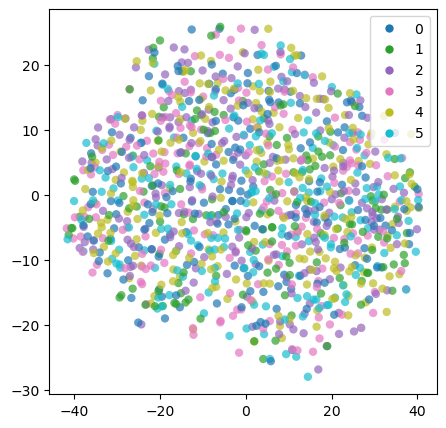

In [9]:
draw_embeddings(corrected_tsne, classes.cohort)

# Save the corrected data set

In [10]:
metabol_exprs.to_csv("../ExposomeChallengeData/datasets/metabol_joint_corrected_minmax.csv")